In [1]:
import pandas as pd
import numpy as np
import jsonlines
import leidenalg
import time
from tqdm import tqdm
from collections import defaultdict

# Load Publication Data from jsonlines file

In [2]:
publications = []
with jsonlines.open("./data/openalex_publications.jsonl") as f_in:
    for pub in f_in:
        publications.append(pub)
num_docs = len(publications)
num_docs

12693

# Define functions to cleanup title and abstract strings
Normalise diacritics, remove punctuation and digits

In [4]:
import re
import string
import unicodedata
from tldextract import extract

translator = str.maketrans('', '', string.punctuation.replace('_',''))

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def remove_punctuation_accents(s):
    #if isinstance(s, str):
    #    s = unicode(s, 'utf-8')
    without_diacritics = strip_accents(s)
    without_punctuation = without_diacritics.translate(translator).lower()
    without_digits = " ".join([s for s in without_punctuation.split() if not s.isdigit()])
    return without_digits

def normalise_string(s):
    return remove_punctuation_accents(s.strip().replace('-', '_'))

# Extract Title and Abstract Text

In [5]:
texts = []
for pub in publications:
    title = normalise_string(pub['display_name'])
    abstract_text = None
    if pub.get('abstract_inverted_index'):
        position_tokens = {}
        for token in pub['abstract_inverted_index']:
            for position in pub['abstract_inverted_index'][token]:
                position_tokens[position] = token
        abstract_text_elems = []
        for i in range(min(position_tokens.keys()), max(position_tokens.keys())+1):
            if i in position_tokens:
                abstract_text_elems.append(position_tokens[i])
            else:
                # sometimes tokens are omitted, just continue
                continue
        abstract_text = normalise_string(" ".join(abstract_text_elems))
    if abstract_text:
        texts.append("{} {}".format(title, abstract_text))
    else:
        texts.append(title)

In [7]:
from nltk.corpus import stopwords
# define stopwords
stop_words = stopwords.words('english')

# Create TFIDF Model

Use the scikit-learn CountVectorizer and TfidfTransformer to convert text data to matrix of term weights

In [8]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# threshold for max features
max_features = 100000

# increase max_ngram for bigrams (2) or trigrams(3)
max_ngram = 1
count_vectorizer = CountVectorizer(
    ngram_range=(1, max_ngram),
    strip_accents='unicode',
    stop_words=stop_words,
    max_df=0.2,    
    min_df=3,
    lowercase=True,
    analyzer='word',
    #token_pattern=r"(?u)\b\w\w+\b"
    max_features=max_features,
)
fact_count_vec = count_vectorizer.fit_transform(texts)

In [9]:
transformer = TfidfTransformer()
fact_tfidf_vec = transformer.fit_transform(fact_count_vec)
num_docs, num_terms = np.shape(fact_tfidf_vec)
np.shape(fact_tfidf_vec)

(12693, 22592)

# Run Topic Modelling
This examples uses NMF to factorise the term-weight matrix. You could use gensim or other libraries to create LDA / LSI or other models

In [10]:
from sklearn.decomposition import NMF

# specify the number of topics you want
num_topics = 20

# Run NMF
This shouldn't take more than a few seconds for samples of ~10K

In [11]:
%%time
nmf_model = NMF(
    n_components=num_topics,
    max_iter=400,
    random_state=42,
    init='nndsvdar',
    verbose=1
)
nmf_doc_topic_weights = nmf_model.fit_transform(fact_tfidf_vec)
nmf_topic_word_weights = nmf_model.components_

violation: 1.0
violation: 0.21992455877604092
violation: 0.13723862067224554
violation: 0.09350878933787951
violation: 0.06537032698338237
violation: 0.048444497644375084
violation: 0.03799400198897486
violation: 0.03141757848061932
violation: 0.027157884688681914
violation: 0.02364298538036068
violation: 0.020853724175313063
violation: 0.01864348260541621
violation: 0.016981775777173788
violation: 0.01553039262596977
violation: 0.01418849951247178
violation: 0.012741925697559352
violation: 0.011253180656425853
violation: 0.009786971290289685
violation: 0.008384873663383906
violation: 0.007111354426284859
violation: 0.006119946107146004
violation: 0.005410422795674689
violation: 0.0048809517831406475
violation: 0.0044621910473175985
violation: 0.004147303556077378
violation: 0.003918101426654641
violation: 0.003748935189159471
violation: 0.0036165280532794945
violation: 0.0035169352301597334
violation: 0.0034429003191172227
violation: 0.003386892551394157
violation: 0.00334213078211034

Specify a threshold to consider doc->topic assignment. Use 95th Percentile

In [12]:
th = np.percentile(nmf_doc_topic_weights, 95)
th

0.03943061478254412

# Create topic labels

In [13]:
vocab = count_vectorizer.get_feature_names() #num_docs, num_terms = np.shape(fact_tfidf_vec)
topic_terms_list = []
topic_doc_count = []
for topic_no in range(0, num_topics):
    topic_doc_count.append((nmf_topic_word_weights[topic_no,:] > th).sum())
    terms = []
    for vi in np.argsort(nmf_topic_word_weights[topic_no,:])[-10:][::-1]:
        terms.append(vocab[vi])
    topic_terms_list.append(terms)
    
topic_labels = ["{}: [n={:,}] {}".format(t, topic_doc_count[t], "|".join(term_list)) for t, term_list in enumerate(topic_terms_list)]

/Users/mszomszor/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
topic_labels

['0: [n=703] outbreak|surveillance|epidemic|reported|imported|epidemiological|years|outbreaks|pakistan|system',
 '1: [n=319] dan|yang|dengan|di|dbd|pada|penelitian|demam|ini|adalah',
 '2: [n=472] case|report|acute|patient|rare|syndrome|manifestations|neurological|severe|complications',
 '3: [n=190] climate|change|temperature|incidence|rainfall|factors|humidity|climatic|weather|correlation',
 '4: [n=234] extract|larvae|aegypti|ppm|concentration|leaf|extracts|leaves|larvicidal|papaya',
 '5: [n=247] knowledge|prevention|attitude|practices|regarding|respondents|practice|among|students|community',
 '6: [n=127] de|la|en|el|del|que|los|se|para|da',
 '7: [n=215] igm|ns1|positive|igg|samples|elisa|antigen|antibodies|detection|test',
 '8: [n=51] tertiary|care|hospital|india|centre|admitted|profile|south|center|teaching',
 '9: [n=386] denv|vaccine|serotypes|cells|viral|serotype|protein|four|viruses|immune',
 '10: [n=289] model|models|transmission|dynamics|prediction|mathematical|spatial|regressio

# Create topic dendrogram

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, linkage, cophenet

topic_dist = 1 - cosine_similarity(nmf_doc_topic_weights.T)
linkage_matrix = ward(topic_dist) #define the linkage_matrix using ward clustering pre-computed distances

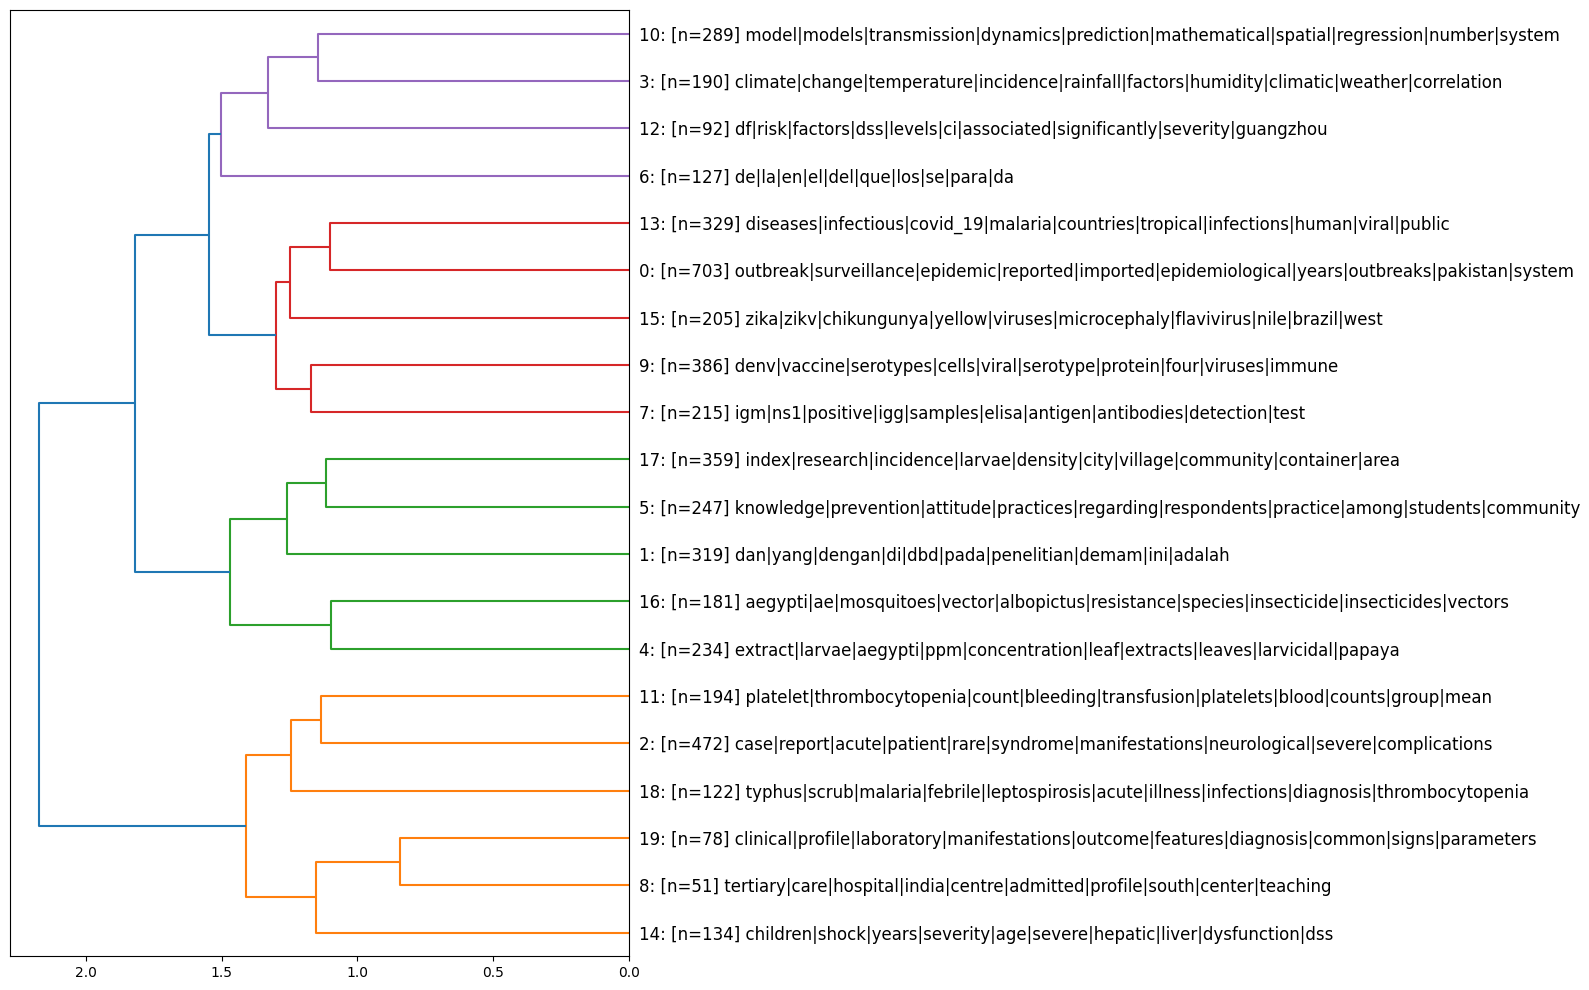

In [27]:
import matplotlib.pyplot as plt

with plt.rc_context({'lines.linewidth': 1.5}):
    width = 16
    height = num_topics * .5
    fig, ax = plt.subplots(figsize=(width, height)) # set size
    ddata = dendrogram(
        linkage_matrix,
        orientation="left",
        labels=topic_labels,
        #leaf_font_size=10,
    )
    plt.tight_layout() #show plot with tight layout
    plt.savefig("./analysis/topic_dendrogram_n={}_dendrogram.pdf".format(num_topics), dpi=200)
    #plt.close(fig)                
    plt.show()

# Visualize document -> topics using UMAP

In [18]:
import umap

/Users/mszomszor/.pyenv/versions/3.9.8/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
%%time 
umapper = umap.UMAP(
    n_neighbors=150,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    verbose=True,
    densmap=True
)
topic_embeddings_2d = umapper.fit_transform(nmf_doc_topic_weights)

UMAP(angular_rp_forest=True, densmap=True, metric='cosine', n_neighbors=150, random_state=42, verbose=True)
Wed Jun  8 21:39:51 2022 Construct fuzzy simplicial set
Wed Jun  8 21:39:51 2022 Finding Nearest Neighbors
Wed Jun  8 21:39:51 2022 Building RP forest with 11 trees


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Wed Jun  8 21:39:55 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Wed Jun  8 21:40:45 2022 Finished Nearest Neighbor Search
Wed Jun  8 21:40:49 2022 Construct embedding
Wed Jun  8 21:40:50 2022 Computing original densities


Epochs completed: 100%| ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 400/400 [00:39]

Wed Jun  8 21:42:33 2022 Finished embedding
CPU times: user 2min 41s, sys: 3.11 s, total: 2min 44s
Wall time: 2min 42s


In [20]:
df_topic_embeddings = pd.DataFrame(topic_embeddings_2d).rename(columns={0: 'topic x', 1: 'topic y'})

We now have an x-y coordinate for every document that we can plot using a scatter plot

In [21]:
df_topic_embeddings

,topic x,topic y
0,0.815709,12.153969
1,5.709376,7.739736
2,1.809711,10.002436
3,0.908253,11.685554
4,5.463806,7.692358
...,...,...
12688,1.795299,8.926726
12689,-1.955681,8.984210
12690,-2.014717,11.545093
12691,3.792382,8.778369


Specify a palette with 20 colours

In [22]:
palette = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
len(palette)

20

Create a dataframe with basic publication metadata to join with the x-y coordinates generated

In [23]:
pub_records = []
for doc_id, pub in enumerate(publications):
    topic = np.argmax(nmf_doc_topic_weights[doc_id,:])
    topic_weight = nmf_doc_topic_weights[doc_id,topic]
    hex_colour = palette[topic]
    
    pub_records.append({
        'doc_id': doc_id,
        'cited_by_count': pub['cited_by_count'],        
        'topic': topic,
        'topic_weight': topic_weight,
        'topic_label': topic_labels[topic],
        'hex_colour': hex_colour,
    })

In [24]:
df_topics = pd.DataFrame(pub_records).merge(df_topic_embeddings, left_index=True, right_index=True)

# Create UMAP Plot

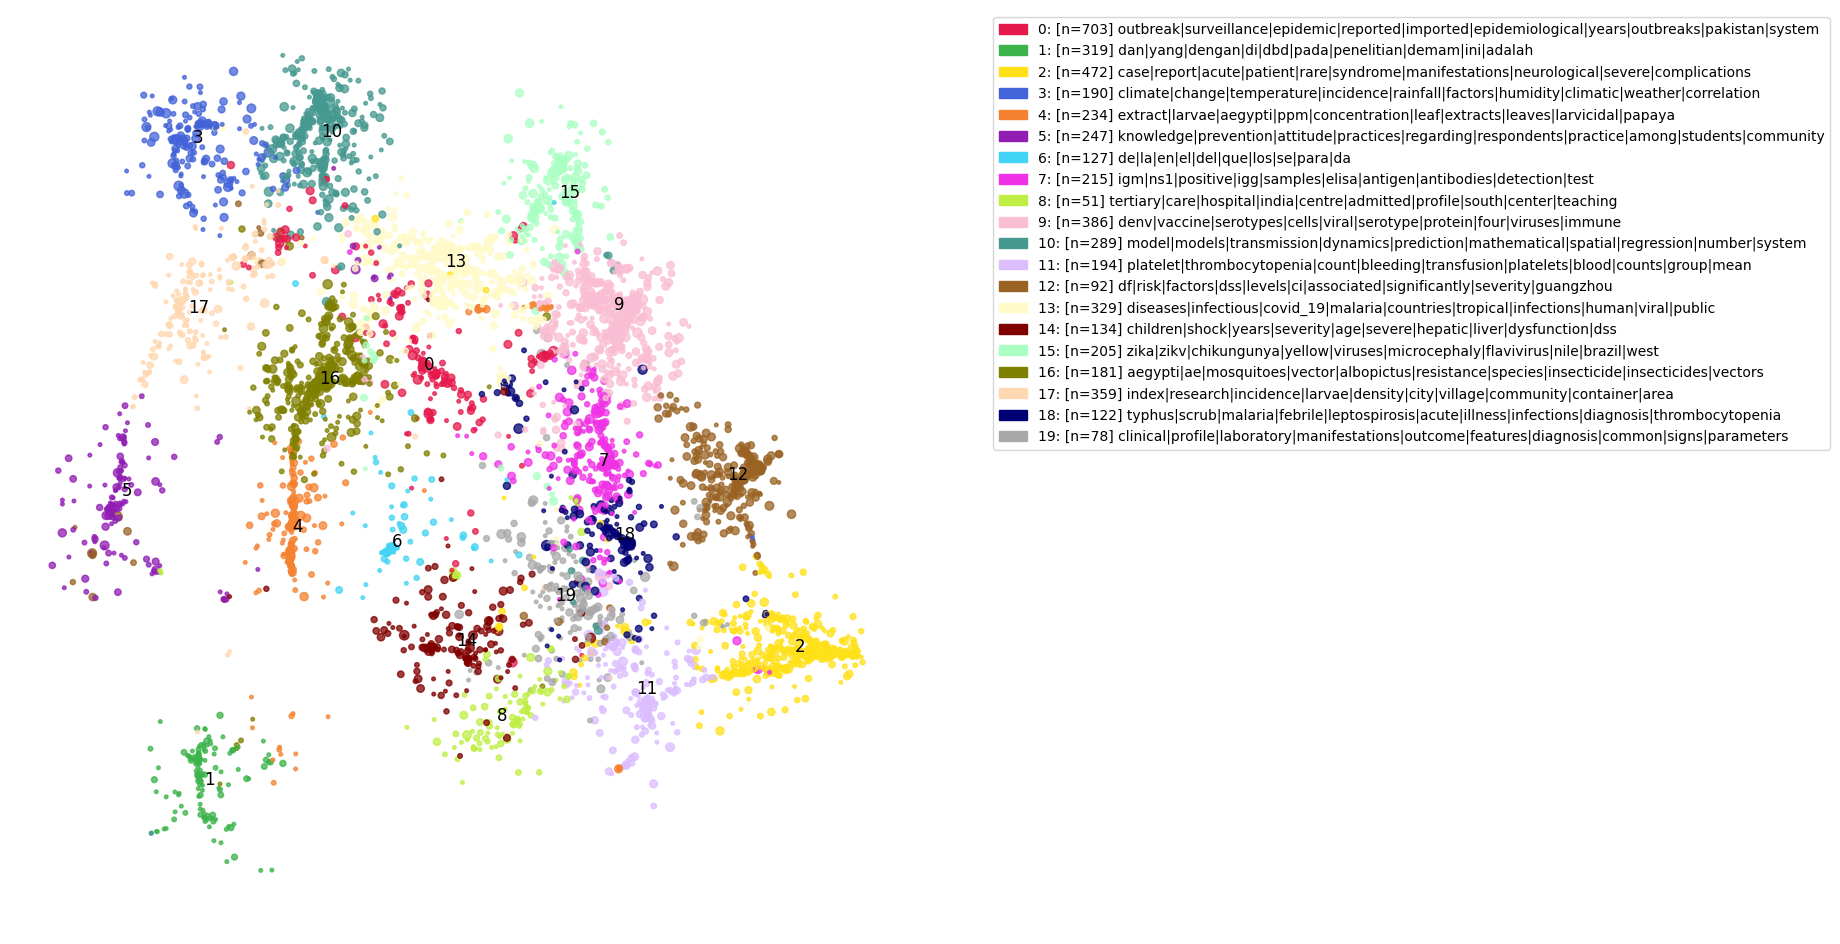

In [28]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_topics['topic x'],
    df_topics['topic y'],
    c=df_topics['hex_colour'],
    s=np.log1p(df_topics['cited_by_count'])*10, 
    alpha=0.75
)

legend_handles = []
for topic in range(num_topics):
    hex_colour = palette[topic]
    
    x = np.median(df_topics[df_topics['topic']==topic]['topic x'])
    y = np.median(df_topics[df_topics['topic']==topic]['topic y'])
    ax.text(x,y, '{}'.format(topic), fontsize=12, color='#000000')
    legend_handles.append(
        mpatches.Patch(color=hex_colour, label='{}'.format(topic_labels[topic]))
    )        
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor('white')
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1.0))
#plt.tight_layout()
plt.savefig("./analysis/publication_topic_umap.png", dpi=150, bbox_inches='tight')
plt.show()

Write the doc_id -> topic assignment information to a file

In [26]:
df_topics.to_csv("./data/publication_topics.csv", index=False)